## Introduction

**[Project Description]**


Sentiment analysis can be used for assessing brand performance and associating an generic attitude towards the brand. job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

The information of main attributes for this project as follows;

* **`airline_sentiment`** : Sentiment classification.(positivie, neutral, and negative)
* **`negativereason`** : Reason selected for the negative opinion
* **`airline`** : Name of 6 US Airlines('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
* **`text`** : Customer's opinion

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import seaborn as sns

import pickle, joblib

## Data Load

In [2]:
connection = sqlite3.connect('./database.sqlite')
query = "SELECT * FROM sqlite_master"
db = pd.read_sql_query(sql = query, con = connection)
db

,type,name,tbl_name,rootpage,sql
0,table,Tweets,Tweets,2,CREATE TABLE Tweets (\n tweet_id INTEGER PR...


In [3]:
query = "Select airline, text, negativereason, airline_sentiment as sentiment from 'Tweets'"
df = pd.read_sql_query(sql = query, con = connection)
display(df.shape, df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airline         14485 non-null  object
 1   text            14485 non-null  object
 2   negativereason  14485 non-null  object
 3   sentiment       14485 non-null  object
dtypes: object(4)
memory usage: 452.8+ KB


(14485, 4)

,airline,text,negativereason,sentiment
0,Delta,@JetBlue's new CEO seeks the right balance to ...,,neutral
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative


None

## EDA

### Total count per Airlines

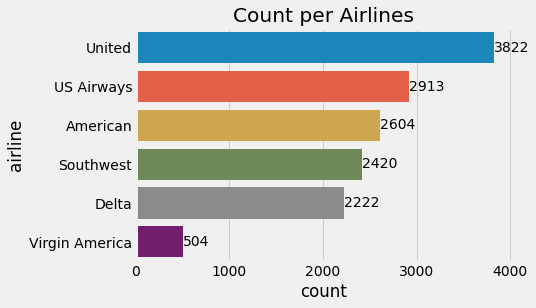

In [4]:
ax = sns.countplot(data = df, y = 'airline',
                   order = df.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)
                                    
plt.show()

### Proportion of Sentiments

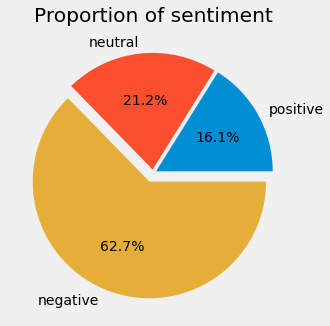

In [5]:
x = df.sentiment.value_counts().sort_values()
plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')
plt.show()

In [6]:
a = df.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
a

sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


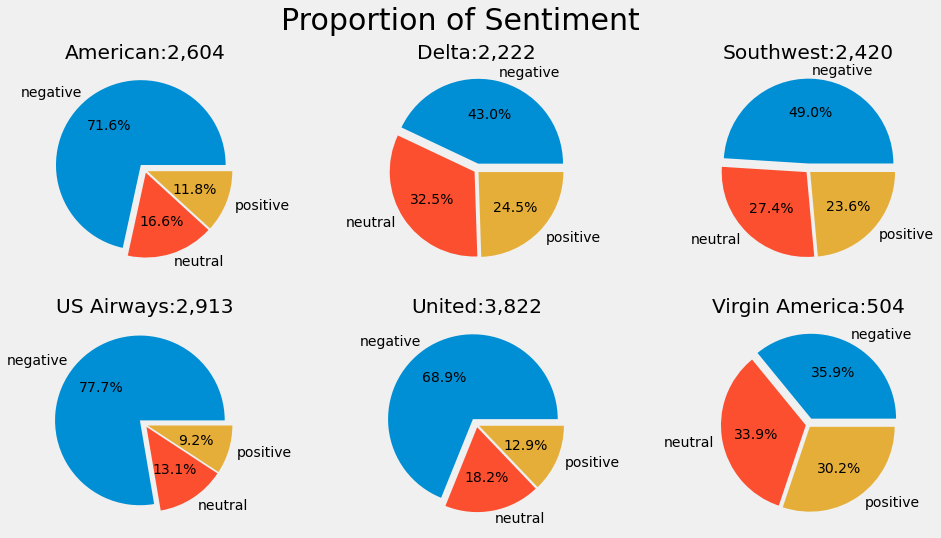

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()

for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("Proportion of Sentiment", fontsize = 30)    
plt.show()

### Reason for Negative sentiment

Negative sentiment only has the value of negativereason.

In [8]:
df_neg = df[df.sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9082, 4)

,airline,text,negativereason,sentiment
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative
5,United,@united and don't hope for me having a nicer f...,Bad Flight,negative


Customer service issue, as a whole, is the main reason for the negative sentiment to the airlines.
The following is the detail sorted by airlines' name.

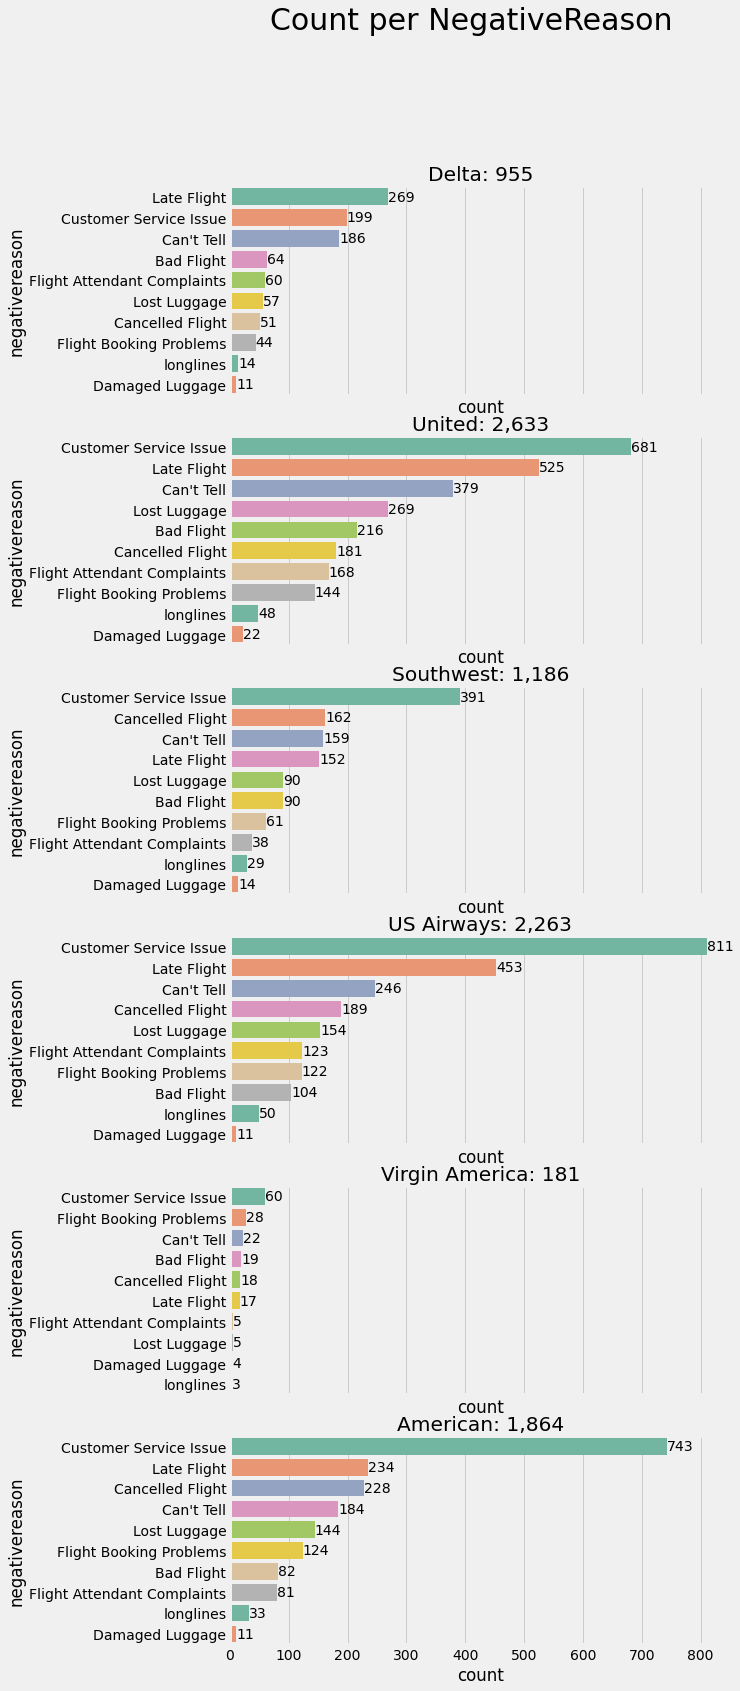

In [9]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = df_neg[df_neg.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = df_neg[df_neg.airline==name].negativereason.value_counts().index, ax = n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline==name]),',')}")
   
plt.suptitle("Count per NegativeReason", fontsize = 30)
plt.show()

In [10]:
names = df.airline.unique()
for name in names:
    print(f"{name} : Out of total {format(len(df[df.airline == name]),',')}customers, {(len(df_neg[df_neg.airline == name]) / len(df[df.airline == name]))*100:.1f}% feel negative.\n")

Delta : Out of total 2,222customers, 43.0% feel negative.

United : Out of total 3,822customers, 68.9% feel negative.

Southwest : Out of total 2,420customers, 49.0% feel negative.

US Airways : Out of total 2,913customers, 77.7% feel negative.

Virgin America : Out of total 504customers, 35.9% feel negative.

American : Out of total 2,604customers, 71.6% feel negative.



### Inference
* **`American`, `US Airways`, `Southwest`**: Complaints about customer sevice issue is relatively high.

* **`United`** : Customer service issue is the most, but customers for this airline experienced late flight more frequently than others. Lost luggage issue happened relatively high.

* **`Delta`**: Customer service looks not bad, but most of customers experienced late flight.

* **`Virgin America`**: Mostly about customer service followed by flight booking problem.

<br>

## Text Preprocessing 

* Tweet text is consisted of 103 length in average.
* Minimum length is 12, and maximum one is 186.

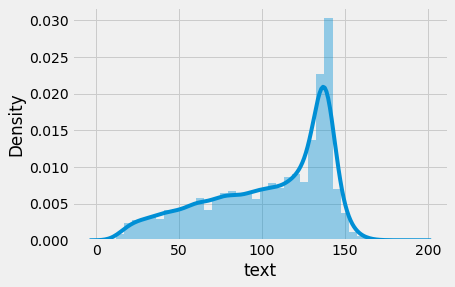

In [11]:
sns.distplot(df.text.str.len())

plt.show()

In [12]:
df.text.str.len().describe()

count    14485.000000
mean       103.836452
std         36.260307
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

### Procedure
* Regular expression
* Tokenization
* Checking Stopwords

In [13]:
import nltk
import re

from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0    [new, ceo, seeks, right, balance, please, pass...
1                  [really, getting, nerves, nothappy]
2    [yes, waited, line, almost, hour, passengers, ...
3    [got, gate, iah, time, given, seats, closed, k...
4    [cool, bags, take, bit, longer, dont, give, ba...
Name: final_text, dtype: object

In [15]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch 

really getting nerves nothappy 

im alist preferred customer loyal swa however inflight wifi better today years ago 

got added thank 

lieslieslies worst travel experience life day clothes vaca lostluggage unprofessional pit mia


<br>

## Text Analysis

# Edit
### Lexicon based approach

The lexicon-based approach involves calculating orientation for a document from the semantic orientation of words or phrases in the document.it uses dictionaries of words annotated with the word's semantic orientation, or polarity.

Here we will just try to verify the lexicon works hopefully very well to classify the sentiment which has already been allocated by the real customers.

# Edit

#### Vader

Vader is a lexicon made for the sentiment analysis of text data on social media.

It returns the compounded polarity score of a sentence after calculating the negative, the neutral, and the positive scores of each word in a sentence.

We can use Vader from the inner module in nltk as well as the Python API [vaderSentiment](https://pypi.org/project/vaderSentiment/).

VADER has many advantages over traditional sentiment analysis methods: [source](https://ichi.pro/ko/python-eseo-vaderleul-sayonghayeo-gamjeong-bunseog-dansunhwa-sosyeol-midieo-tegseuteu-274770204542255)

* **It works very well with social media type text**, but generalizes easily to multiple domains.
* It does not require any training data, but consists of a generalized, balence-based, human-curated gold standard psychological vocabulary.
* It's fast enough to use online with streaming data,
* The speed-performance trade-off isn't serious.



In [16]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182}

In [17]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.text[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.text[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.text[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.text[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

print(df.text[10000])
print(texts[10000])
print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')

@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch
new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182} --> Actual Classification: neutral 

@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy
really getting nerves nothappy
{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.1725} --> Actual Classification: negative 

Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
wanted get bag benefit instead get pricing three tickets adding card mp visa option
{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.4588} --> Actual Classification: negative 

@SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.
im alist preferred customer loyal swa h

<br>

We realize that some clear sentences could be classified as almost same as the actual classification.

But the very ambiguous(or sarcastic) senteces such as:
* Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
* @SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.

Sometimes Vader didn't work well to classify the real sentiment and this shows the limitation of current NLP and the way to go at the same time.


<br>

<br>

### WordCloud : Keyword analysis

WordCloud is one of the easiest way to show which word mainly(frequently) appears in the set of sentences.

But it can be just one of pieces of visulalization if there's no appropriate text preprocessing before drawing it. 

In [18]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = df[df.sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = df[df.sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = df[df.sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

114853 585364 149515


In [19]:
from wordcloud import WordCloud

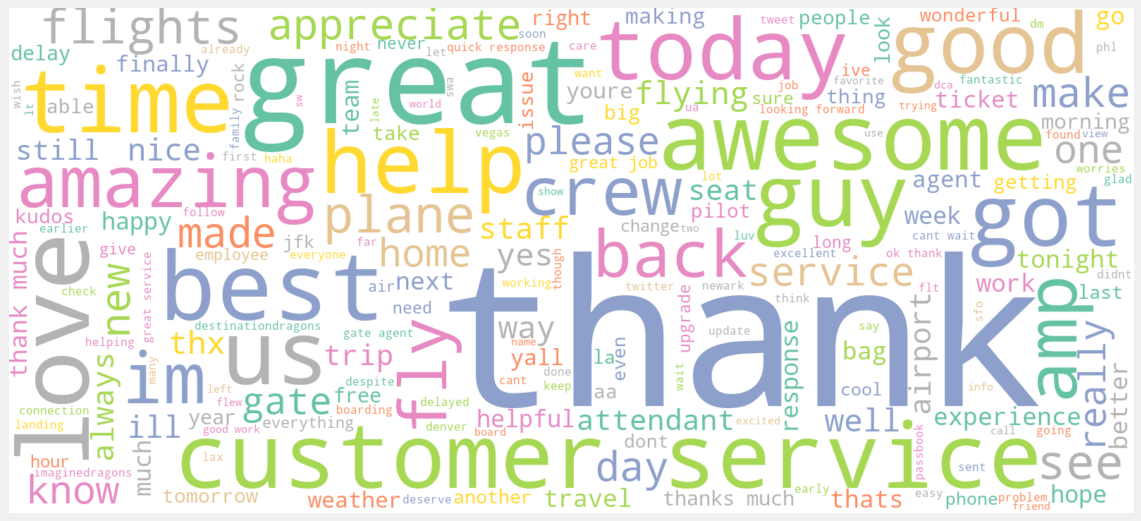

In [20]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

We can see many positive words such as 'thank', 'great', 'love', etc.

<br>

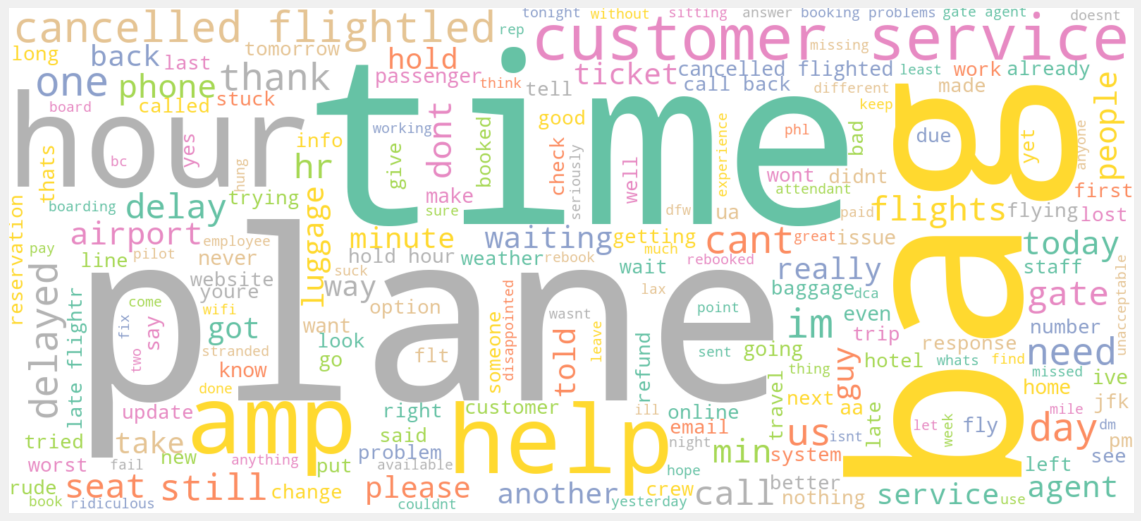

In [21]:
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

The main words we can see in the WC of negative sentiment is 'plane', 'bag', 'time', 'customer', 'service', etc.

<br>

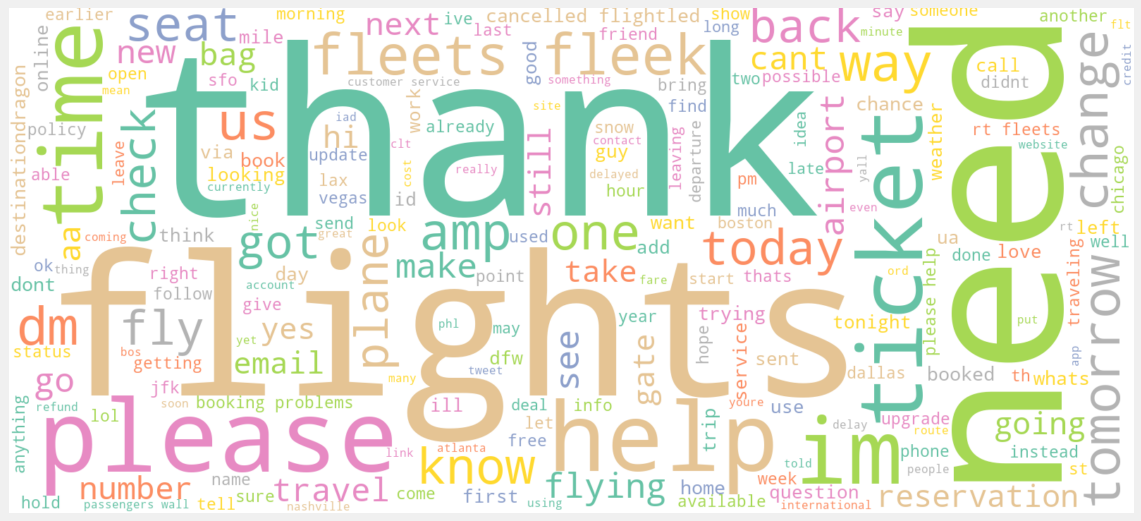

In [22]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

neutral is just neutral. The only positive word we can see at a glance is 'thank'.
Almost no negative and positive words.

<br>